In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import estimate


def entropy(p):
    p_nonzero = p[p > 0]
    return -np.sum(p_nonzero * np.log2(p_nonzero))


def MI_deter(pxy_dict):
    """
    If deterministic joint distribution, the entropy of X and the entropy of
    (X,Y) are the same. Thus, MI = H(Y).
    """
    Ys = list(pxy_dict.values())
    Y_counts = pd.Series(Ys).value_counts()
    pY = Y_counts / len(Ys)
    return entropy(pY)


X_bits = 20
Y_bits = 10
dist_type = "zipf1"

# deterministic joint distribution
if dist_type == "uniform":
    rand_ys = np.random.choice(2**Y_bits, 2**X_bits, replace=True)
elif dist_type == "half":
    p = [3] * (2**Y_bits // 2) + [1] * (2**Y_bits // 2)
    p = np.array(p, dtype=float)
    p /= np.sum(p)
    rand_ys = np.random.choice(2**Y_bits, 2**X_bits, replace=True, p=p)
elif dist_type == "zipf1":
    p = 1 / np.arange(1, 2**Y_bits + 1)
    p /= np.sum(p)
    rand_ys = np.random.choice(2**Y_bits, 2**X_bits, replace=True, p=p)
M_dict = {x: y for x, y in zip(range(2**X_bits), rand_ys)}
MI_ground_truth = MI_deter(M_dict)
print("MI_ground_truth:", MI_ground_truth)

MI_ground_truth: 7.512669020426564


In [27]:
# sample_bits = X_bits / 2
# num_samples = int(2**sample_bits)
# rand_xs = np.random.choice(2**X_bits, num_samples, replace=False)
# rand_ys = np.array([M_dict[x] for x in rand_xs])
# MI_sample = entropy(pd.Series(rand_ys).value_counts() / num_samples)
# print("MI_sample:", MI_sample)

In [28]:
sample_bit_list = range(1, X_bits + 1)
MI_sample_list = []
MI_min_list = []
MI_max_list = []
MI_miller_list = []
MI_chao_list = []
X_sample_list = []
for sample_bits in sample_bit_list:
    num_samples = int(2**sample_bits)
    rand_xs = np.random.choice(2**X_bits, num_samples, replace=False)
    X_sample_list.append(rand_xs)
    rand_ys = np.array([M_dict[x] for x in rand_xs])
    value_cnts_y = pd.Series(rand_ys).value_counts()

    MI_sample = entropy(value_cnts_y / num_samples)
    MI_sample_list.append(MI_sample)

    num_unique_ys = len(value_cnts_y)
    MI_miller = MI_sample + (num_unique_ys - 1) / (2 * num_samples)
    MI_miller_list.append(MI_miller)

    sample_abundance = sorted(list(value_cnts_y), reverse=True)
    p_detected, p_undetected = estimate.estimate_multinomial(
        sample_abundance, 2**Y_bits, num_samples, 2**Y_bits, False
    )
    p_estimated = np.concatenate([p_detected, p_undetected])
    p_estimated = p_estimated / np.sum(p_estimated)
    MI_chao = entropy(p_estimated)
    MI_chao_list.append(MI_chao)

    remain_xs = 2**X_bits - num_samples
    value_cnts_min_y = value_cnts_y.copy()
    max_y = value_cnts_y.idxmax()
    value_cnts_min_y[max_y] = value_cnts_min_y[max_y] + remain_xs
    MI_min = entropy(value_cnts_min_y / 2**X_bits)
    MI_min_list.append(MI_min)

    value_cnts_max_y = value_cnts_y.copy()
    value_cnts_max_y = pd.concat(
        [
            value_cnts_max_y,
            pd.Series([1] * remain_xs, index=range(num_samples, 2**X_bits)),
        ]
    )
    MI_max = entropy(value_cnts_max_y / 2**X_bits)
    MI_max_list.append(MI_max)

/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T/ipykernel_30801/2872157533.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series([1] * remain_xs, index=range(num_samples, 2**X_bits)),


,num_samples,MI_sample,MI_min,MI_max,MI_miller,MI_chao
0,2,1.000000,0.000020,20.000000,1.250000,1.000000
1,4,2.000000,0.000061,20.000000,2.375000,2.000000
2,8,3.000000,0.000143,20.000000,3.437500,3.000000
3,16,3.274397,0.000225,19.999989,3.618147,2.742235
4,32,4.090018,0.000519,19.999972,4.418143,6.382908
5,64,5.101813,0.001081,19.999945,5.437751,6.689399
6,128,5.887347,0.002309,19.999864,6.195940,7.256243
7,256,6.074022,0.004178,19.999530,6.314256,7.177241
8,512,6.556065,0.008347,19.998807,6.760166,7.414669
9,1024,6.792625,0.015823,19.996868,6.957176,7.476602


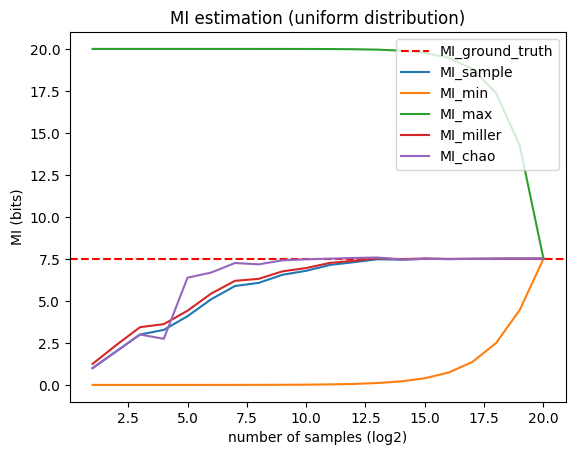

In [29]:
df = pd.DataFrame(
    {
        "num_samples": 2 ** np.array(sample_bit_list),
        "MI_sample": MI_sample_list,
        "MI_min": MI_min_list,
        "MI_max": MI_max_list,
        "MI_miller": MI_miller_list,
        "MI_chao": MI_chao_list,
    }
)
display(df)

# plot
fig, ax = plt.subplots()
ax.axhline(
    y=MI_ground_truth, color="r", linestyle="--", label="MI_ground_truth"
)
ax.plot(sample_bit_list, MI_sample_list, label="MI_sample")
ax.plot(sample_bit_list, MI_min_list, label="MI_min")
ax.plot(sample_bit_list, MI_max_list, label="MI_max")
ax.plot(sample_bit_list, MI_miller_list, label="MI_miller")
ax.plot(sample_bit_list, MI_chao_list, label="MI_chao")
ax.set_xlabel("number of samples (log2)")
ax.set_ylabel("MI (bits)")
ax.set_title("MI estimation (uniform distribution)")
ax.legend()
plt.show()

In [8]:
# rand_xs = X_sample_list[6]
# num_samples = 2**7
# print("rand_xs:")
# display(rand_xs)
# rand_ys = np.array([M_dict[x] for x in rand_xs])
# print()
# print("rand_ys:")
# display(rand_ys)
# value_cnts_y = pd.Series(rand_ys).value_counts()
# print()
# print("value_cnts_y:")
# display(value_cnts_y)
# p_empirical = value_cnts_y / num_samples
# print("empirical probability:")
# display(p_empirical)
# MI_sample = entropy(p_empirical)
# print()
# print("MI_sample:", MI_sample)
# sample_abundance = sorted(list(value_cnts_y), reverse=True)
# print()
# print("sample_abundance:")
# display(sample_abundance)
# p_detected, p_undetected = estimate.estimate_multinomial(
#     sample_abundance, 2**Y_bits, num_samples, 2**Y_bits, True
# )
# print()
# print("p_detected, p_undetected:")
# display(p_detected)
# display(p_undetected)
# p_estimated = np.concatenate([p_detected, p_undetected])
# # p_estimated = p_estimated / np.sum(p_estimated)
# print()
# print("p_estimated:")
# display(p_estimated)
# MI_chao = entropy(p_estimated)
# print()
# print("MI_chao:", MI_chao)

In [9]:
# # plot p_empirical and p_estimated
# fig, ax = plt.subplots()
# max_idx = max(len(p_empirical), len(p_estimated))
# p_empirical = np.pad(p_empirical, (0, max_idx - len(p_empirical)))
# p_estimated = np.pad(p_estimated, (0, max_idx - len(p_estimated)))
# ax.plot(range(1, max_idx + 1), p_empirical, label="empirical")
# ax.plot(range(1, max_idx + 1), p_estimated, label="estimated")
# ax.set_xlabel("Y")
# ax.set_ylabel("probability")
# ax.set_title("empirical and estimated probability")
# ax.legend()
# plt.show()

In [10]:
# from collections import Counter
# from math import ceil
# from scipy.optimize import fsolve

# sample_abundance = sorted(list(value_cnts_y), reverse=True)
# n = sum(sample_abundance)
# fvec = Counter(sample_abundance)
# print(f"n: {n}")
# print(f"fvec: {fvec}")
# cov_1 = estimate.cov_first_order(n, fvec[1], fvec[2])
# print(f"cov_1: {cov_1}")
# cov_2 = estimate.cov_second_order(n, sample_abundance, fvec[2], fvec[3])
# print(f"cov_2: {cov_2}")
# xixi_1 = estimate.summation_xi_xi_minus_1(sample_abundance)
# print(f"xixi_1: {xixi_1}")
# fn_detected = estimate.gen_detected_adj_model(
#     sample_abundance, n, cov_1, cov_2, xixi_1
# )
# lambda_, theta = fsolve(fn_detected, [0.5, 0.5], maxfev=10000, factor=0.1)
# print(f"lambda_: {lambda_}, theta: {theta}")
# print(f"fn_detected: {fn_detected((lambda_, theta))}")
# cov_deficit_1 = estimate.cov_deficit_first_order(n, fvec[1], fvec[2])
# print(f"cov_deficit_1: {cov_deficit_1}")
# cov_deficit_2 = estimate.cov_deficit_second_order(
#     n, sample_abundance, fvec[2], fvec[3]
# )
# print(f"cov_deficit_2: {cov_deficit_2}")
# f0 = ceil(estimate.num_undetected_lower_bound(n, fvec[1], fvec[2]))
# print(f"f0: {f0}")
# fn_undetected = estimate.gen_undetected_adj_model(
#     n, cov_deficit_1, cov_deficit_2, xixi_1, f0
# )
# alpha, beta = fsolve(fn_undetected, [0.5, 0.5], maxfev=10000, factor=0.1)
# print(f"alpha: {alpha}, beta: {beta}")
# print(f"fn_undetected: {fn_undetected((alpha, beta))}")